In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
#import cv2
%matplotlib inline
from scipy.stats import norm, multivariate_normal

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Las estrellas de este notebook
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier

from sklearn import datasets


# Boosting

Los métodos de Boosting combinan muchas instancias de un estimador de base. Cada instancia aprende tanto de los datos como de la instancia anterior, combinandolos de cierta manera.

Vamos a ver dos ejemplos: AdaBoosting y GradientBoosting

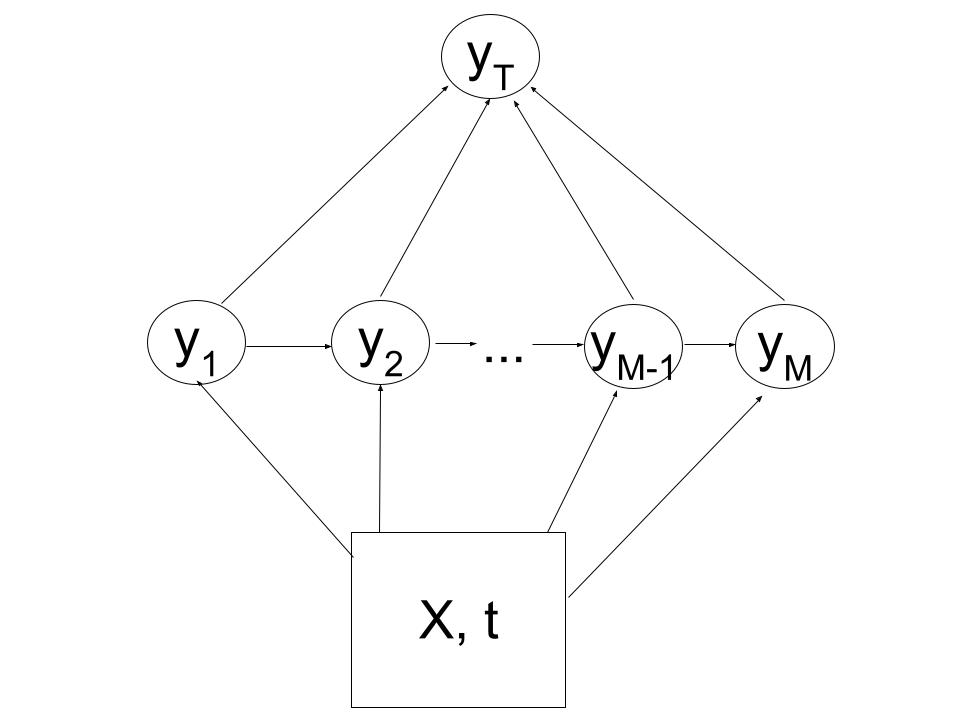

## AdaBoost

Los dos paquetes de sklearn a utilizar son AdaBoostClassifier y AdaBoostRegressor.

Los hiperparametros especificos de AdaBoost son:

*   base_estimator: el predictor debil que utiliza. Por defecto es un DecisionStump.
*   n_estimator: Cuantos estimadores utilizar.
*   learning_rate: La tasa de aprendizaje al tomar un nuevo estimador. A menor learning_rate, se necesitan mas estimadores para fittear los datos. Es un regularizador del algoritmo.
*   algorithm: Exclusivo para clasificacion. El algoritmo de resolucion que utiliza `sklearn`. Hay dos opciones: `SAMME` y `SAMME.R`. El primero vale para todos pero es mas lento en converger. El segundo trabaja con probabilidades y por lo tanto el `base_estimator` necesita tener un `predict_proba`.
*   loss: Exclusivo para regresion. Es que funcion de perdida utiliza el algoritmo. Las opciones son `linear`,`square` y `exponential`.

De la clase fitteada uno puede obtener:

*   estimators_: La lista de los estimadores.
*   estimators_weights_: Los pesos de cada estimador. 1 para clasificacion `SAMME.R`, distinto de 1 para regresion y clasificacion con `SAMME`.
*   estimators_errors_: El error de cada estimador al evaluarse en el conjunto de datos. No es el error al aplicar el ensemble.
*   feature_importances_: La importancia de los features.

Ademas, el AdaBoost posee el .staged_ que permite evaluar el ensemble a cada paso como si estuviese terminado.


### Ejemplo de AdaBoostClassifier con make_moons:

In [56]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Ejemplo `sample_weight`

$ \text{Loss} = \sum_{i}w_{i}\text{Loss}_{i}$

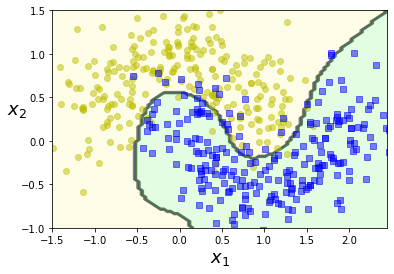

In [14]:
svc = SVC(kernel='rbf')
svc.fit(X_train,y_train,sample_weight=np.where(X_train[:,1]>-0.5,100.0,1.0))
plot_decision_boundary(svc, X, y)

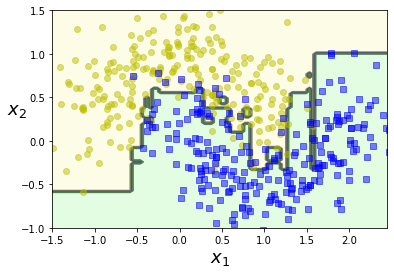

In [37]:
n_estimators=300
#AdaBoostClassifier(base_estimator=SVC/DT/Perceptron/RL,n_estimator= cuantos voy a considerar, algorithm=que algoritmo uso, learning_rate = ,...)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train,y_train)
plot_decision_boundary(ada_clf, X, y)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,ada_clf.predict(X_train))
print(cm)
print(accuracy_score(y_test,ada_clf.predict(X_test)))

[[185   4]
 [  4 182]]
0.896


Veamos un poco los estimadores con sus pesos y su error

In [29]:
print(np.asarray(ada_clf.estimators_).shape)

(300,)


Veamos los pesos y los errores.

(300,)


Text(0, 0.5, 'Peso $\\alpha$')

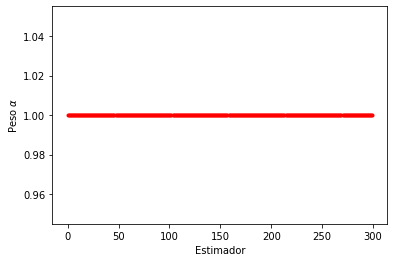

In [30]:
## Si es SAMME.R todos tienen el mismo peso mientras
print(ada_clf.estimator_weights_.shape)
plt.plot(ada_clf.estimator_weights_,'r.')
plt.xlabel('Estimador')
plt.ylabel(r'Peso $\alpha$')

(300,)


Text(0, 0.5, 'Error')

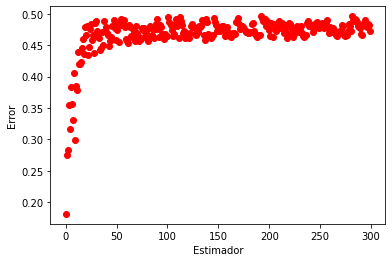

In [31]:
print(ada_clf.estimator_errors_.shape)
plt.plot(ada_clf.estimator_errors_,'ro')
plt.xlabel('Estimador')
plt.ylabel('Error')

Exploremos la evolucion en funcion del numero de estimadores

In [ ]:
for nest, est_pred in enumerate(ada_clf.staged_predict(X_train[:2])):
  print(nest, est_pred[:2])

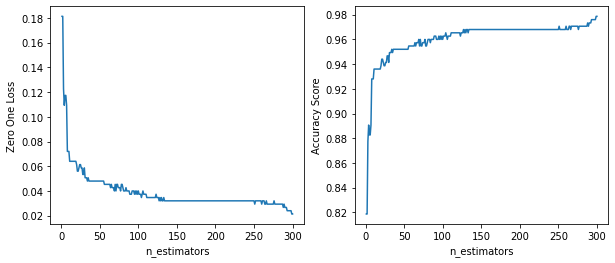

In [32]:
from sklearn.metrics import zero_one_loss, accuracy_score #cuenta la fraccion de mal clasificados

err_train = np.zeros((n_estimators,2))
for i, y_pred in enumerate(ada_clf.staged_predict(X_train)):
  err_train[i,0] = zero_one_loss(y_pred, y_train)
  err_train[i,1] = accuracy_score(y_pred, y_train)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

ax[0].plot(np.arange(n_estimators) + 1, err_train[:,0])
ax[1].plot(np.arange(n_estimators) + 1, err_train[:,1])

ax[0].set_xlabel('n_estimators')
ax[1].set_xlabel('n_estimators')
ax[0].set_ylabel('Zero One Loss')
ax[1].set_ylabel('Accuracy Score')
plt.show()

### Veamos el efecto del Learning rate en la convergencia:

El ejemplo lindo del Geron:

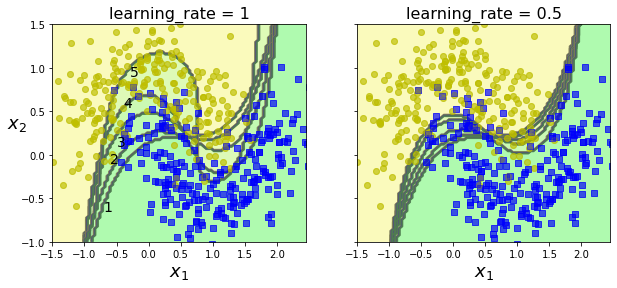

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

Asi lo hice yo

In [ ]:
y_pred.shape

(100, 100)

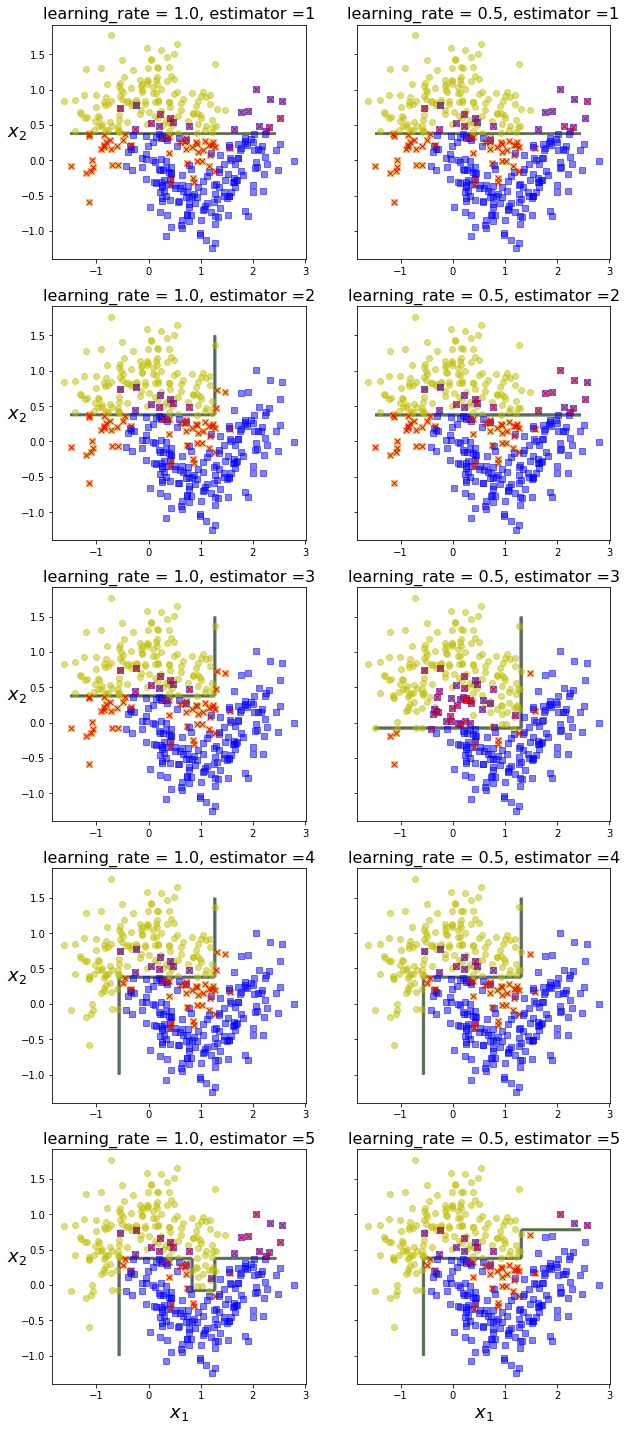

In [68]:
m = len(X_train)

learnings = [1.0,0.5]
fix, axes = plt.subplots(nrows=5,ncols=len(learnings), figsize=(5*len(learnings),25), sharey=True)
for subplot, learning_rate in enumerate(learnings):
    ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=5,
    algorithm="SAMME.R", learning_rate=learning_rate, random_state=42)
    ada_clf.fit(X_train,y_train)
    y_pred_train=np.zeros((5,X_train.shape[0]))
    for nest_train, est_dec_train in enumerate(ada_clf.staged_predict(X_train)):
      y_pred_train[nest_train]=est_dec_train
    #axes=[-1.5, 2.45, -1, 1.5]
    alpha=0.5
    x1s = np.linspace(-1.5, 2.45, 100)
    x2s = np.linspace(-1, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    for nest, est_dec in enumerate(ada_clf.staged_predict(X_new)):
      y_pred_estimator_only=ada_clf.estimators_[nest].predict(X_new).reshape(x1.shape)
      y_pred = est_dec.reshape(x1.shape)
      custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
      axes[nest,subplot].plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "yo", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_pred_train[nest] != y_train], X_train[:, 1][y_pred_train[nest] != y_train], "rx", alpha=1.0)     
      axes[nest,0].set_ylabel(r"$x_2$", fontsize=18, rotation=0)
      axes[nest,subplot].contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
      #axes[nest,subplot].contour(x1, x2, y_pred_estimator_only, cmap='plasma', alpha=0.8)
      axes[nest,subplot].set_title("learning_rate = {}, estimator ={}".format(learning_rate,nest+1), fontsize=16)
#      plt.show()
    axes[-1,subplot].set_xlabel(r"$x_1$", fontsize=18)
plt.show()

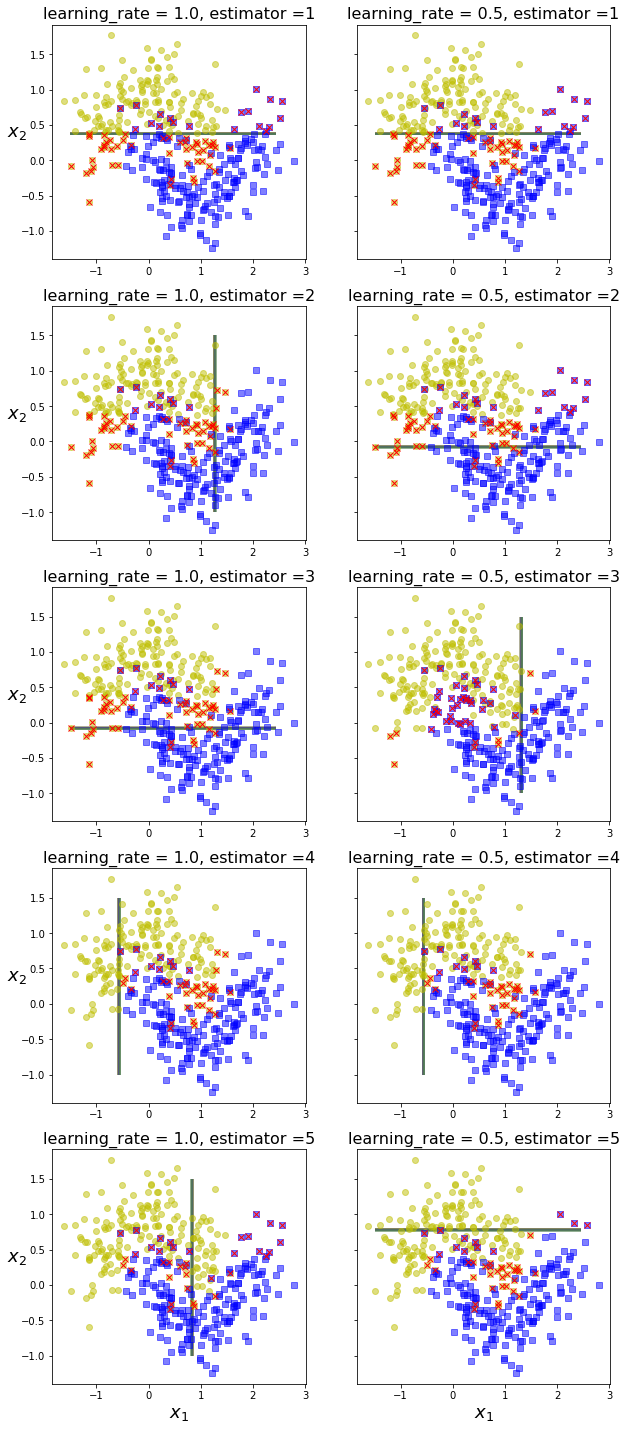

In [62]:
m = len(X_train)

learnings = [1.0,0.5]
fix, axes = plt.subplots(nrows=5,ncols=len(learnings), figsize=(5*len(learnings),25), sharey=True)
for subplot, learning_rate in enumerate(learnings):
    ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=5,
    algorithm="SAMME.R", learning_rate=learning_rate, random_state=42)
    ada_clf.fit(X_train,y_train)
    y_pred_train=np.zeros((5,X_train.shape[0]))
    for nest_train, est_dec_train in enumerate(ada_clf.staged_predict(X_train)):
      y_pred_train[nest_train]=est_dec_train
    #axes=[-1.5, 2.45, -1, 1.5]
    alpha=0.5
    x1s = np.linspace(-1.5, 2.45, 100)
    x2s = np.linspace(-1, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    for nest, est_dec in enumerate(ada_clf.estimators_):
      y_pred = est_dec.predict(X_new).reshape(x1.shape)
      custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
      axes[nest,subplot].plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "yo", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_pred_train[nest] != y_train], X_train[:, 1][y_pred_train[nest] != y_train], "rx", alpha=1.0)     
      axes[nest,0].set_ylabel(r"$x_2$", fontsize=18, rotation=0)
      axes[nest,subplot].contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
      axes[nest,subplot].set_title("learning_rate = {}, estimator ={}".format(learning_rate,nest+1), fontsize=16)
#      plt.show()
    axes[-1,subplot].set_xlabel(r"$x_1$", fontsize=18)
plt.show()

### Aca un ejemplo comparando algoritmos:

Otra virtud del AdaBoost es el stage_predict y stage_predict_proba, que permite ver como evoluciona el error al ir agregando iteraciones. Utilizemoslo para comparar algoritmos y ver la converfencia.

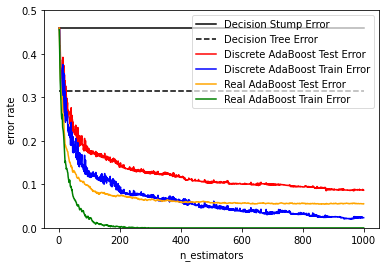

In [54]:
n_estimators = 1000
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)

ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME.R")
ada_real.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

ada_real_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
    ada_real_err[i] = zero_one_loss(y_pred, y_test)

ada_real_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
    ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_real_err,
        label='Real AdaBoost Test Error',
        color='orange')
ax.plot(np.arange(n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

### Un ejemplo de AdaBoostRegressor

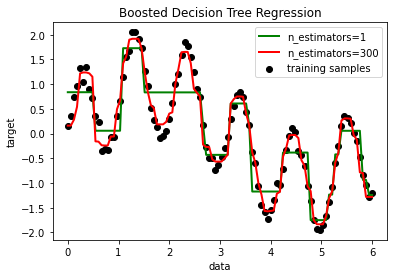

In [53]:
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),loss='square',
                          n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

(300,)


Text(0, 0.5, 'Peso')

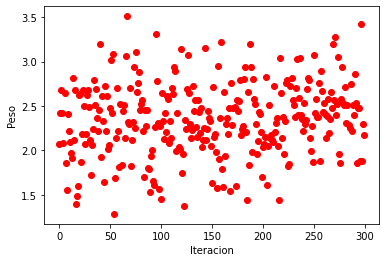

In [49]:
print(regr_2.estimator_weights_.shape)
plt.plot(regr_2.estimator_weights_,'ro')
plt.xlabel('Iteracion')
plt.ylabel('Peso')

(300,)


Text(0, 0.5, 'Error')

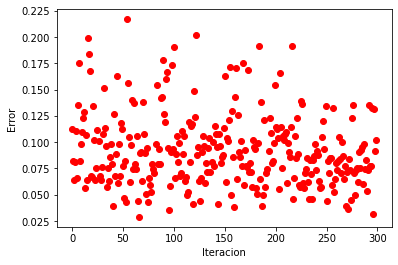

In [50]:
print(regr_2.estimator_errors_.shape)
plt.plot(regr_2.estimator_errors_,'ro')
plt.xlabel('Iteracion')
plt.ylabel('Error')

## GradientBoosting

Antes de utilizar paquetes especificos veamos un ejemplo del Geron que muestra como funciona Gradient Boosting

### Ejemplo del Geron:

GradientBoosting busca al final hacer algo parecido a lo siguiente.

In [76]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X) #residuos del primer árbol
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X) #residuos del segundo árbol
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Y la prediccion seria de esta manera:

In [77]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))#sumo las predicciones
y_pred

array([0.75026781])

Ahora veamoslo de manera grafica

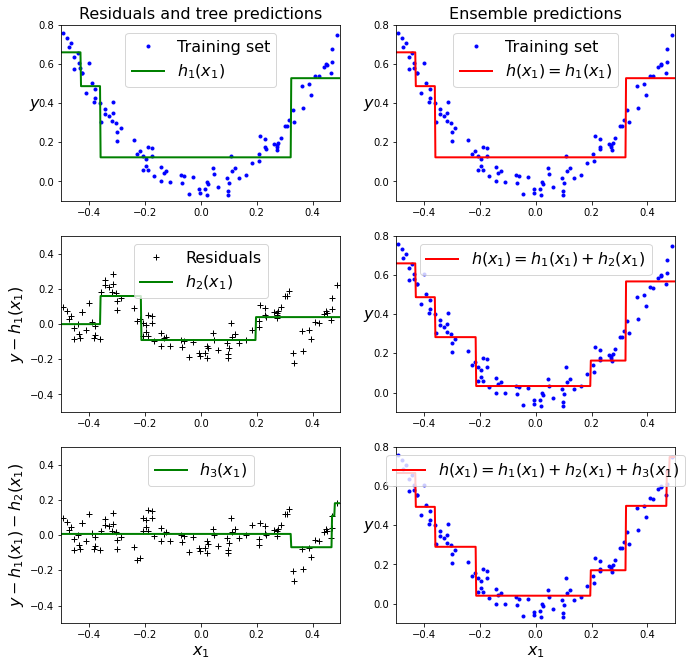

In [87]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### La implementacion en `sklearn`

Los dos paquetes de sklearn a utilizar son GradientBoostingClassifier y GradientBoostingRegressor. Los parametros son un poco mas largos de explicar asi que va charlado.


In [80]:
GradientBoostingClassifier?

In [79]:
GradientBoostingRegressor?

In [81]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

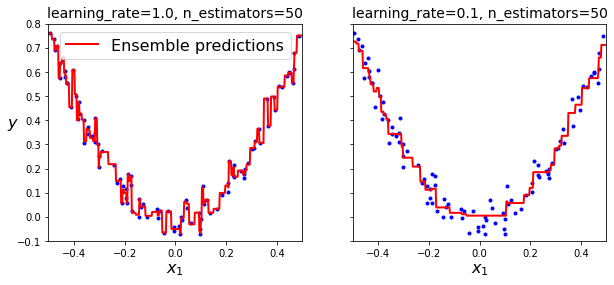

In [82]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

### Eleccion del numero optimo de arboles

Si uno tiene demasiados estimadores, puede sobreajustar. El objetivo es entonces encontrar el numero optimo de estimadores que den un buen ajuste. Esto se puede hacer utilizando lo que se llama **early stopping**. El **early stopping** consiste en utilizar un conjunto de validacion para evaluar el predictor en funcion del numero de estimadores. Si la metrica evaluada en el conjunto de validacion empieza a empeorar, entonces frenamos y nos quedamos con ese numero de estimadores.

In [85]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [np.sqrt(mean_squared_error(y_val, y_pred))
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

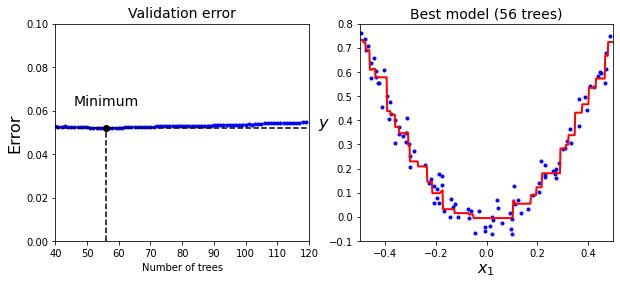

In [95]:
min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([40, 120, 0, 0.1])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Asi como lo hicimos mas arriba, evitamos un poco mas el sobreajuste. Sin embargo, sigo entrenando con todos los estimadores posibles, lo que es costoso. El early stopping puede incorporarse de manera tal que se detenga al momento en que vea el error de validacion comenzar a subir.

Para eso, utilizo la opcion `warm_start`. Esta opcion almacena los arboles utilizados en `.fit` y permite entrenar de manera incremental.

In [109]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [110]:
print(gbrt.n_estimators)
print("Minimo MSE en el conjunto de validacion:", min_val_error)


61
Minimo MSE en el conjunto de validacion: 0.002712853325235463


### Stochastic gradient boosting

Hasta ahora no utilizamos el hiperparametro `subsample`.  Este hiperparametro define si entrenamos cada predictor sobre una fraccion elegida al azar de los datos. Esta tecnica baja la varianza todavia mas y acelera el entrenamiento.

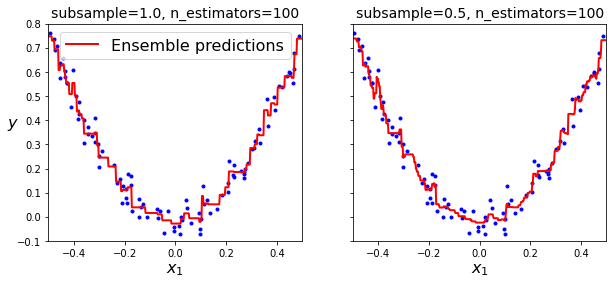

In [108]:
gbrt_all = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1, random_state=42)
gbrt_all.fit(X, y)

gbrt_stochastic = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=0.1,subsample=0.5, random_state=42)
gbrt_stochastic.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_all], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("subsample={}, n_estimators={}".format(gbrt_all.subsample, gbrt_all.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_stochastic], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("subsample={}, n_estimators={}".format(gbrt_stochastic.subsample, gbrt_stochastic.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

### XGBoost

Extreme Gradient Boosting, o `XGBoost`, es una implementacion optimizada de Gradient Boosting que busca ser rapida, escaleable y portatil. Es muy popular (como se puede ver en kaggle) y puede utilizarse de manera similiar a `sklearn` y se juntan muy bien. En particular, la clase `XBGRegressor` es equivalente un modelo de `sklearn`.

In [111]:
import xgboost
from xgboost import XGBRegressor, XGBClassifier

La documentación relevante se encuentra [acá](https://xgboost.readthedocs.io/en/latest/). Los hiperparametros relevantes para nosotros son:

- learning rate (1 por defecto)
- gamma / min_split_loss (0 por defecto): la minima reducción de perdida para que el árbol siga diviendiendo una hoja
- max_depth (6 por defecto)
- min_child_weight (1 por defecto): la minima cantidad de mediciones pesadas que tienen que quedar en un hijo al partir un nodo hoja
- subsample (1 por defecto)
- colsample_bytree, colsample_bylevel, colsample_bynode (1 por defecto los tres): la fracción de features considerados por árbol, por nível y por nodo.
- reg_lambda (1 por defecto): termino de penalización L2 en los pesos
- reg_alpha (0 por defecto): termino de penalización L1 en los pesos
- objective: especifica la tarea a cumplir. 'reg:squarederror' es la pérdida de cuadrados mínimos.  'binary:logistic' o 'multi:softmax'son utiles para clasificación con outputs probabilisticos. Hay varias opciones más para jugar.

In [ ]:
XGBRegressor?

In [112]:
import pandas as pd
from sklearn import datasets
boston = datasets.load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)
print(X.head())
print(X.info())
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train,test_size=0.2)

      CRIM    ZN  INDUS  CHAS    NOX  ...  RAD    TAX  PTRATIO       B  LSTAT
0  0.00632  18.0   2.31   0.0  0.538  ...  1.0  296.0     15.3  396.90   4.98
1  0.02731   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  396.90   9.14
2  0.02729   0.0   7.07   0.0  0.469  ...  2.0  242.0     17.8  392.83   4.03
3  0.03237   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  394.63   2.94
4  0.06905   0.0   2.18   0.0  0.458  ...  3.0  222.0     18.7  396.90   5.33

[5 rows x 13 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-nu

In [113]:
regressor = XGBRegressor(
    n_estimators=200,
    learning_rate=0.5,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='reg:squarederror',
    max_depth=3)

Entrenamos con `fit`, especificando algunos hiperparametros

In [115]:
regressor.fit(X_train_2,y_train_2,eval_set=[(X_train_2, y_train_2), (X_val, y_val)],
        eval_metric='rmse',early_stopping_rounds=5,#viene con early stopping!
        verbose=True)

[0]	validation_0-rmse:12.8136	validation_1-rmse:11.2086
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:6.97078	validation_1-rmse:6.02616
[2]	validation_0-rmse:4.19469	validation_1-rmse:4.20685
[3]	validation_0-rmse:3.03174	validation_1-rmse:3.66959
[4]	validation_0-rmse:2.53065	validation_1-rmse:3.52306
[5]	validation_0-rmse:2.26436	validation_1-rmse:3.53187
[6]	validation_0-rmse:2.07393	validation_1-rmse:3.4981
[7]	validation_0-rmse:1.99243	validation_1-rmse:3.50574
[8]	validation_0-rmse:1.91901	validation_1-rmse:3.50379
[9]	validation_0-rmse:1.86824	validation_1-rmse:3.47084
[10]	validation_0-rmse:1.79043	validation_1-rmse:3.45136
[11]	validation_0-rmse:1.73662	validation_1-rmse:3.46157
[12]	validation_0-rmse:1.68624	validation_1-rmse:3.47966
[13]	validation_0-rmse:1.6611	validation_1-rmse:3.40683
[14]	validation_0-rmse:1.58697	validation_1-rmse:3.43595

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [116]:
np.sqrt(mean_squared_error(regressor.predict(X_val),y_val))

3.3957212789570512

In [117]:
regressor.evals_result()

{'validation_0': {'rmse': [12.813593,
   6.970781,
   4.194687,
   3.031738,
   2.530648,
   2.264362,
   2.073933,
   1.992434,
   1.91901,
   1.868241,
   1.790434,
   1.736623,
   1.686236,
   1.661102,
   1.586974,
   1.51614,
   1.453986,
   1.400896,
   1.352225,
   1.296395,
   1.264089,
   1.232242,
   1.165661]},
 'validation_1': {'rmse': [11.208567,
   6.02616,
   4.206845,
   3.669585,
   3.523057,
   3.531869,
   3.498095,
   3.505739,
   3.503787,
   3.470843,
   3.451356,
   3.461572,
   3.479657,
   3.40683,
   3.435948,
   3.423469,
   3.412003,
   3.396195,
   3.395721,
   3.425881,
   3.428269,
   3.41772,
   3.443493]}}

Podemos explorar la importancia de los features:

In [118]:
for i in range(len(boston.feature_names)):
  print((boston.feature_names[i],regressor.feature_importances_[i]))

('CRIM', 0.030044738)
('ZN', 0.01089583)
('INDUS', 0.019015338)
('CHAS', 0.0030304943)
('NOX', 0.0881063)
('RM', 0.4063603)
('AGE', 0.019649161)
('DIS', 0.07100928)
('RAD', 0.0182927)
('TAX', 0.020428361)
('PTRATIO', 0.026911214)
('B', 0.019817317)
('LSTAT', 0.2664389)


Dado que esta tan optimizado y es tan rapido, probemos con `cross_val_score`.

In [119]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(regressor,X_train,y_train,scoring='neg_root_mean_squared_error')
print(-scores.mean(),scores.std())

3.7814989133031367 0.725432850899673


Una vez entrenado, es posible guardar el modelo

In [121]:
regressor.save_model('xbg_modelo_1.json')

In [126]:
params=regressor.get_xgb_params()
regressor_2=XGBRegressor(**params)
regressor_2.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.0,
 'importance_type': 'gain',
 'learning_rate': 0.5,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'nthread': 1,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

In [127]:
regressor_2.load_model('xbg_modelo_1.json')
regressor_2.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0.0,
 'importance_type': 'gain',
 'learning_rate': 0.5,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 200,
 'nthread': 1,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

In [128]:
regressor.predict(X_train[:2])

array([22.477568, 22.889889], dtype=float32)

In [129]:
regressor_2.predict(X_train[:2])

array([22.795559, 22.807165], dtype=float32)

# Breakout

Implementen y optimicen un AdaBoost y un GradientBoost para los datasets grandes de la clase pasada

## Datasets más grandes

###  Regresión; volviendo a California

In [ ]:
HOUSING_PATH = "datasets"

In [ ]:
import os
import sys
if 'google.colab' in sys.modules:
        
    import tarfile

#     DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
#     HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
    DOWNLOAD_ROOT = "https://github.com/IAI-UNSAM/datasets/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "housing/housing_pp_"

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        for tt in ['train', 'test']:
            full_path = housing_url + tt + '.csv'
            !wget {full_path} -P {housing_path}
            
    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

--2021-05-27 00:51:50--  https://github.com/IAI-UNSAM/datasets/raw/master/housing/housing_pp_train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv [following]
--2021-05-27 00:51:50--  https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/housing/housing_pp_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3070968 (2.9M) [text/plain]
Saving to: ‘datasets/housing_pp_train.csv’

housing_pp_train.cs 100%[===================>]   2.93M  13.1MB/s    in 0.2s    

2021-05-27 00:51:51 (13.1 MB/s) - ‘datasets/housing_pp_train.csv’ sav

In [ ]:
import pandas as pd

def load_preprocessed_housing_data(housing_path=HOUSING_PATH, kind='train'):
    assert kind in ['train', 'test'], "kind must be 'train' or 'test'"
    
    csv_path = os.path.join(housing_path, "housing_pp_{}.csv".format(kind))
    return pd.read_csv(csv_path)

# The function loads the data as a Pandas DataFrame instance.
housing_train = load_preprocessed_housing_data(kind='train')
housing_test = load_preprocessed_housing_data(kind='test')

In [ ]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   longitude               14856 non-null  float64
 1   latitude                14856 non-null  float64
 2   housing_median_age      14856 non-null  float64
 3   total_rooms             14856 non-null  float64
 4   total_bedrooms          14856 non-null  float64
 5   population              14856 non-null  float64
 6   households              14856 non-null  float64
 7   median_income           14856 non-null  float64
 8   bedrooms_per_rooms      14856 non-null  float64
 9   bedrooms_per_household  14856 non-null  float64
 10  median_house_value      14856 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB


In [ ]:
# Predictor variables (in a matrix, as required by sklearn)
X = housing_train.drop('median_house_value', axis=1, inplace=False)
t = housing_train.median_house_value.values

X_test = housing_test.drop('median_house_value', axis=1, inplace=False)
t_test = housing_test.median_house_value.values

print(X.shape, t.shape)

(14856, 10) (14856,)


###  Clasificación; MNIST

In [ ]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'plasma',
               interpolation="nearest")
    plt.axis("off")

## Dataset nuevo

Y agreguemos un dataset más por si quieren probar algo nuevo

En un experimento como el LHC se buscan nuevas particulas (llamémosla $W^\prime$), que decaen no siempre al mismo estado final. Por ejemplo, puede ocurrir que una colisión protón-protón produzca una partícula muy masiva que decae produciendo dos jets (o lluvias de partículas), llamados *leading* y *sub-leading*. Cada uno de estos jets se encuentra caracterizado por  7 parámetros: la masa invariante ($M_j$), el momento transverso ($P_T$), su rapidez relativista ($Y$), su angulo azimutal ($\phi$) y tres variables ($\tau_{21}, \tau_{31}, \tau_{32}$), que miden cuánta subestructura posee cada jet.

Contamos con un conjunto de datos de 10000 colisiones donde efectivamente se produce esta partícula nueva ($W^\prime$, que llamamos *señal*) y otros 10000 donde la colisión no llevo a la creación de esta partícula (pero sí de muchas otras, que no son de interés). Estos últimos eventos constituyen entonces el *background* de la medición. 

El objetivo es usar las características de los jets para clasificar las colisiones de las cuales provienen en las dos clases: *señal* o *background*.

El siguiente codigo importa los datos y hace una visualización. No hace falta que hagan más gráficos, pero son bienvenidos a explorar los datos en mayor detalle.

In [ ]:
import os
import sys
housing_path='datasets'
os.makedirs(housing_path, exist_ok=True)
# Para lxs que estén en colab; si trabajás en local, deberías tener los datos accesibles al haber clonado el repo.
if 'google.colab' in sys.modules:
    #Para descargar los datos al directorio actual, ejecute la siguiente linea
    !wget https://github.com/IAI-UNSAM/datasets/raw/master/np_signal.dat -P {housing_path}
    !wget https://github.com/IAI-UNSAM/datasets/raw/master/np_background.dat -P {housing_path}

--2021-05-27 14:37:29--  https://github.com/IAI-UNSAM/datasets/raw/master/np_signal.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/np_signal.dat [following]
--2021-05-27 14:37:30--  https://raw.githubusercontent.com/IAI-UNSAM/datasets/master/np_signal.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2671353 (2.5M) [text/plain]
Saving to: ‘datasets/np_signal.dat’

np_signal.dat       100%[===================>]   2.55M  --.-KB/s    in 0.1s    

2021-05-27 14:37:30 (23.9 MB/s) - ‘datasets/np_signal.dat’ saved [2671353/2671353]

--2021-05-27 14:37:30--  https://gith

In [ ]:
background=[]
# Lee los eventos de background
with open('datasets/np_background.dat') as backgroundfile:
  for nline, line in enumerate(backgroundfile):
    if(nline<10000):
      Line=line.split(";")
      # separa los datos del jet *leading* de los del jet *sub-leading*, los transforma en float
      # y construye un array de dimensiones [10000, 2, 7] (evento, jet, feature)
      background_1=list(map(lambda x: float(x), Line[0].split(',')))
      background_2=list(map(lambda x: float(x), Line[1].split(',')))
      background.append([background_1,background_2])
    
background=np.asarray(background)

# Hace lo mismo para los datos de la señal.
signal=[]
with open('datasets/np_signal.dat') as signalfile:
  for nline,line in enumerate(signalfile):
    if(nline<10000):
      Line=line.split(";")
      signal_1=list(map(lambda x: float(x),Line[0].split(',')))
      signal_2=list(map(lambda x: float(x),Line[1].split(',')))
      signal.append([signal_1,signal_2])
signal=np.asarray(signal)

print('Shape de background y señal:', background.shape, signal.shape)

# Combina los datos de backgroud y señal de cada jet, asigna labels 0 = background y 1 = señal
X = np.vstack((background, signal))
Y = np.hstack((np.zeros(len(background)), np.ones(len(signal))))

print('Shape de datos y labels:', X.shape, Y.shape)

Shape de background y señal: (10000, 2, 7) (10000, 2, 7)
Shape de datos y labels: (20000, 2, 7) (20000,)


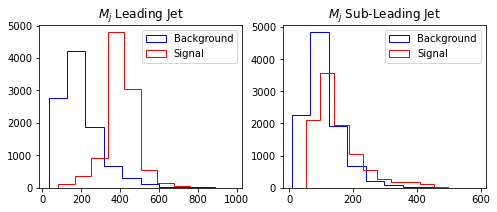

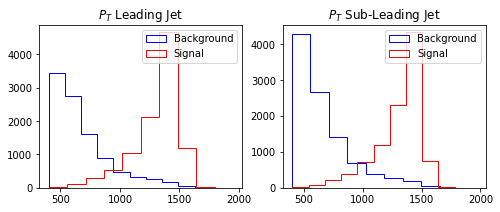

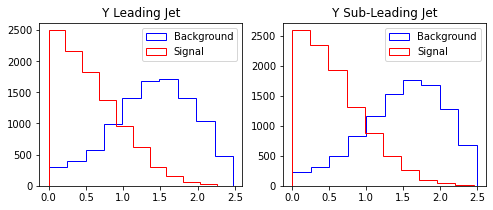

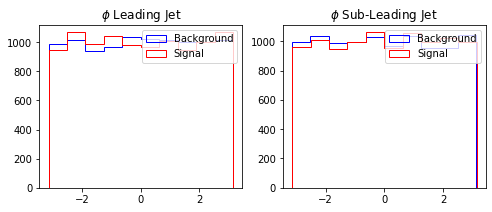

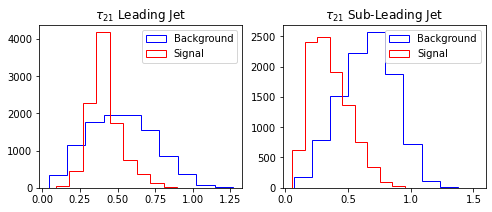

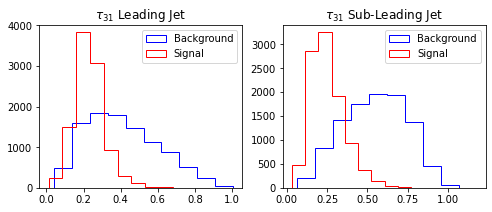

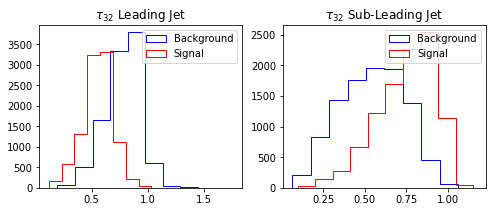

In [ ]:
import matplotlib.pyplot as plt
vars=['$M_j$','$P_T$','Y','$\phi$',r'$\tau_{21}$',r'$\tau_{31}$',r'$\tau_{32}$']

# Hacemos un histograma de cada variable por separado, para cada jet y cada clase.
for i in range(7):
  fig, axs = plt.subplots(1,2,figsize=(8,3))
  axs[0].hist(background[:,0,i],histtype='step',color='blue',label='Background')
  axs[0].hist(signal[:,0,i],histtype='step',color='red',label='Signal')
  axs[0].legend(loc='upper right')
  axs[0].set_title(vars[i]+' Leading Jet')
  axs[1].hist(background[:,1,i],histtype='step',color='blue',label='Background')
  axs[1].hist(signal[:,1,i],histtype='step',color='red',label='Signal')
  axs[1].legend(loc='upper right')
  axs[1].set_title(vars[i]+' Sub-Leading Jet')
  plt.show()

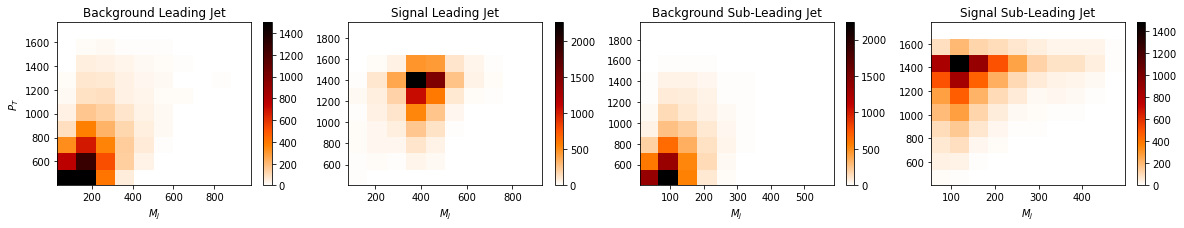

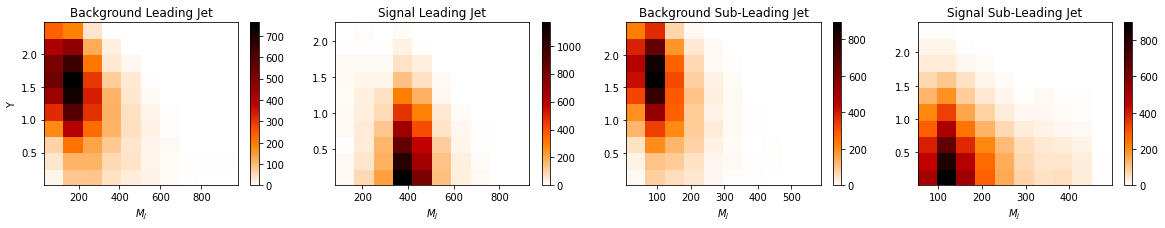

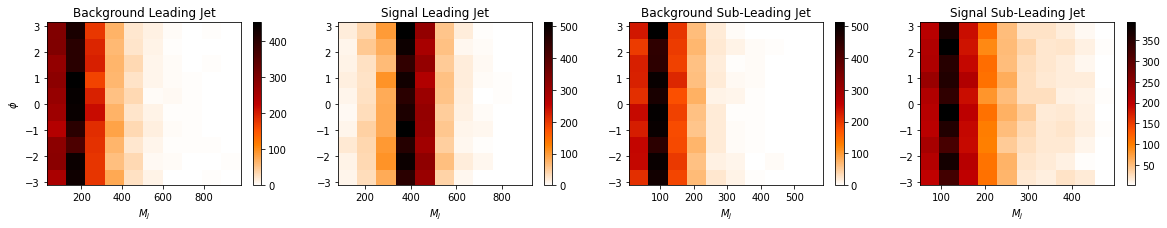

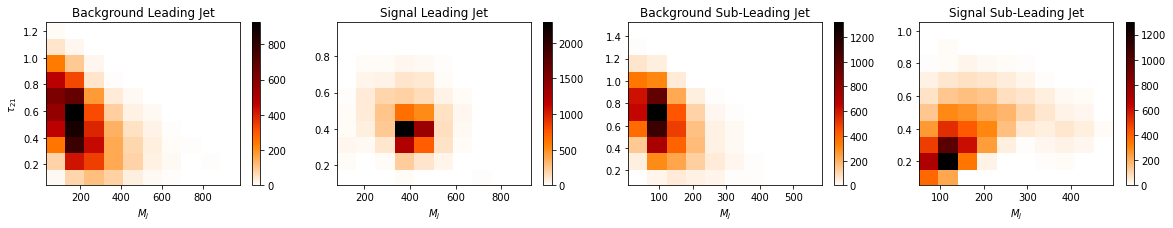

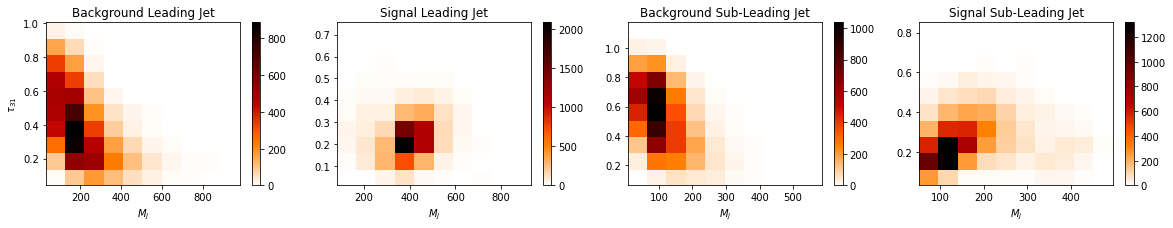

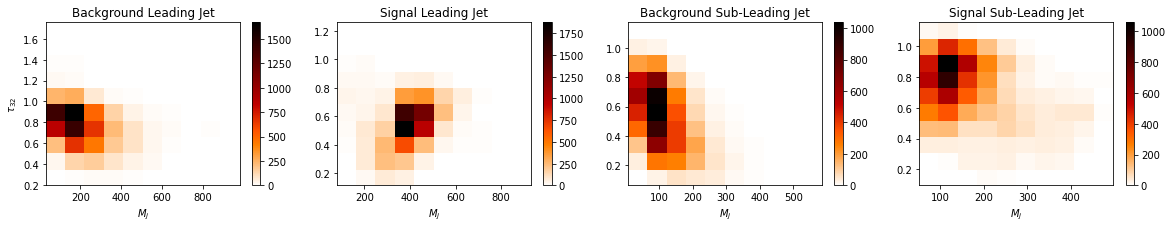

In [ ]:
# Mostramos correlaciones de los parámetros de cada jet con la masa invariante.
for i in range(6):
  fig, axs = plt.subplots(1,4,figsize=(20,3))
  f1=axs[0].hist2d(background[:,0,0],background[:,0,1+i],cmap='gist_heat_r')
  fig.colorbar(f1[3], ax=axs[0])
  axs[0].set_xlabel(vars[0])
  axs[0].set_ylabel(vars[1+i])
  axs[0].set_title('Background Leading Jet')
  f2=axs[1].hist2d(signal[:,0,0],signal[:,0,1+i],cmap='gist_heat_r')
  fig.colorbar(f2[3], ax=axs[1])
  axs[1].set_xlabel(vars[0])
  #axs[1].set_ylabel(vars[1+i])
  axs[1].set_title('Signal Leading Jet')
  f3=axs[2].hist2d(background[:,1,0],background[:,1,1+i],cmap='gist_heat_r')
  fig.colorbar(f3[3], ax=axs[2])
  axs[2].set_xlabel(vars[0])
  axs[2].set_title('Background Sub-Leading Jet')
  f4=axs[3].hist2d(signal[:,1,0],signal[:,1,1+i],cmap='gist_heat_r')
  axs[3].set_xlabel(vars[0])
  axs[3].set_title('Signal Sub-Leading Jet')
  fig.colorbar(f4[3], ax=axs[3])
  plt.show()

Para estos datos, entrenen un Clasificador con Boosting para cada jet por separado y para ambos jets en conjunto. Obtenga las feature importances en cada caso. Comparen con un clasificador simple para decidir si valió la pena hacer Boosting.